# Comparación entre bag generators

### Generación de los datos
Generamos las bags reales a partir de las que luego vamos a generar nuevas bags

In [1]:
from dlquantification.utils.utils import APPBagGenerator
import torch

#generate data
y = torch.randint(0, 3, (5000,))

bag_generator = APPBagGenerator('cpu', seed=2032)
_, real_bags_p = bag_generator.compute_bags(n_bags=1000, bag_size=100, y=y)

print(real_bags_p)


tensor([[0.4100, 0.1600, 0.4300],
        [0.0200, 0.7700, 0.2100],
        [0.5900, 0.1300, 0.2800],
        ...,
        [0.1500, 0.1300, 0.7200],
        [0.3300, 0.2300, 0.4400],
        [0.1000, 0.7000, 0.2000]])


### Funciones de utilidad

In [2]:
import ternary
import numpy as np
from sklearn.neighbors import KernelDensity

def plot_simplex(p):
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="black", multiple=0.1)

    # Plot the points
    tax.scatter(p.numpy(), marker='o', color='blue', s=10, alpha=0.5)

def plot_simplex_heatmap(p):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(p.numpy())

    def get_density(p):
        return np.exp(kde.score(np.array(p).reshape(1,-1)))

    figure, tax = ternary.figure(scale=50)
    tax.heatmapf(get_density, boundary=True, style="triangular")
    tax.boundary(linewidth=2.0)


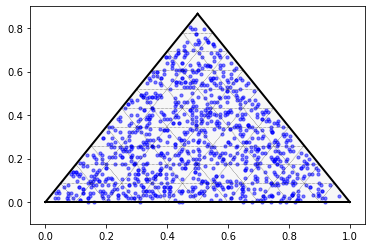

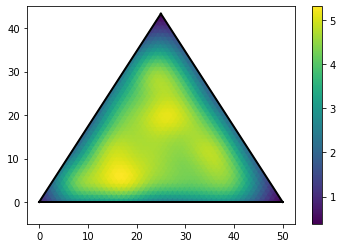

In [3]:
plot_simplex(real_bags_p)
plot_simplex_heatmap(real_bags_p)

### Usando UnlabeledMixerBagGenerator
Este mixer coge dos muestras aleatorias y las mezcla

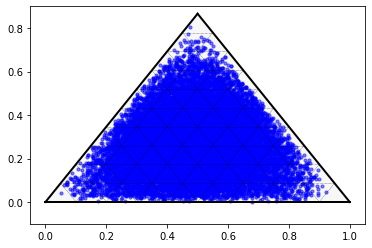

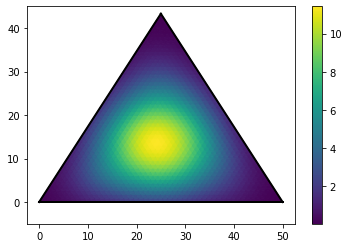

In [4]:
from dlquantification.utils.utils import UnlabeledMixerBagGenerator

unlabeled_bag_generator = UnlabeledMixerBagGenerator(device='cpu', prevalences=real_bags_p, sample_size=100, real_bags_proportion=0, seed=2032)

_, prevalences = unlabeled_bag_generator.compute_bags(n_bags=20000, bag_size=100, y=y)
plot_simplex(prevalences)
plot_simplex_heatmap(prevalences)

como se puede ver todo queda centrado en el centro del simplexo. Para solucionar eso tenemos el parámetro real_bags_proportion que también mete bags reales.

### Parámetro real_bags_proportion
El parámetro real_bags_proportion indica que proporción de las bags devueltas son reales y cuales son mezcla.

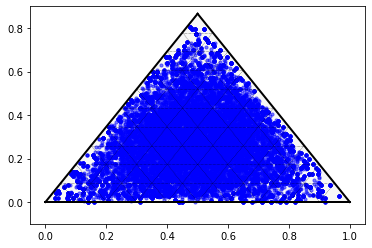

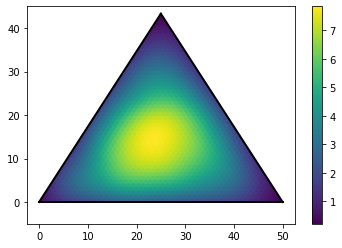

In [5]:
unlabeled_bag_generator = UnlabeledMixerBagGenerator(device='cpu', prevalences=real_bags_p, sample_size=100, real_bags_proportion=0.5, seed=2032)

_, prevalences = unlabeled_bag_generator.compute_bags(n_bags=20000, bag_size=100, y=y)
plot_simplex(prevalences)
plot_simplex_heatmap(prevalences)

La cosa mejora pero realmente casi el 50% de las muestras las estamos metiendo en el centro del simplexo. Si subimos real_bags_proportion lo evitaremos pero siempre estaremos generando las mismas muestras.

### UnlabeledMixerBagGeneratorV4 
Este mixer no coge dos bags aleatorias sino que coge prioritariamente bags que están cercas unas de otras

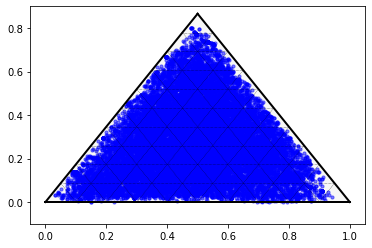

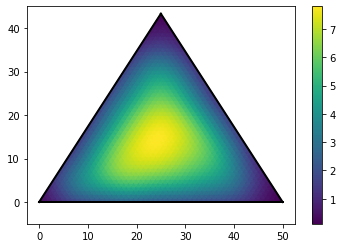

In [6]:
from dlquantification.utils.utils import UnlabeledMixerBagGeneratorV4
unlabeled_bag_generator = UnlabeledMixerBagGeneratorV4(device='cpu', prevalences=real_bags_p, sample_size=100, real_bags_proportion=0, seed=2032)

_, prevalences = unlabeled_bag_generator.compute_bags(n_bags=20000, bag_size=100, y=y)
plot_simplex(prevalences)
plot_simplex_heatmap(prevalences)

va un poco mejor y el dibujo se parece más al original aunque seguimos teniendo mucha más densidad en el centro.

### Unlabeled UnlabeledMixerBagGeneratorV4 con real_bags_proportion=0.5

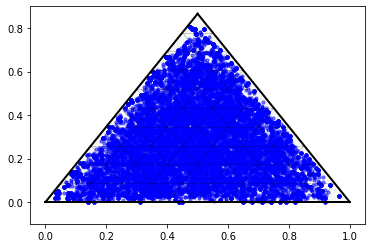

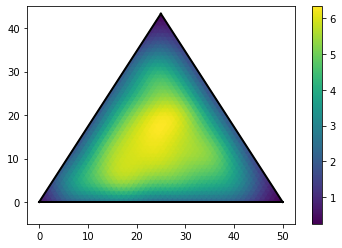

In [7]:
from dlquantification.utils.utils import UnlabeledMixerBagGeneratorV4
unlabeled_bag_generator = UnlabeledMixerBagGeneratorV4(device='cpu', prevalences=real_bags_p, sample_size=100, real_bags_proportion=0.5, seed=2032)

_, prevalences = unlabeled_bag_generator.compute_bags(n_bags=20000, bag_size=100, y=y)
plot_simplex(prevalences)
plot_simplex_heatmap(prevalences)

### Ideas
Creo que lo ideal sería que con real_bags_proportion=0 se conservase lo más posible la distribución de las bags originales.
Una posible solución podría ser darle más peso a las muestras que estén cercas unas de otras. ¿Hacer que la probabilidad esté realacionada con la inversa de la distancia al cuadrado?